In [1]:
#Pruebas regresión multiple
import mysql.connector  # Importar el conector de MySQL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score




# sns.set()


config = {
    'user': 'root',
    'password': 'root',  # Ajusta la contraseña según tu configuración de MySQL
    'host': '127.0.0.1',  # IP del host (localhost)
    'port': 3306,         # Puerto de MySQL
    'database': 'deforestacion'  # Base de datos que quieres consultar
}

try:
    # Establecer la conexión
    conn = mysql.connector.connect(**config)
    print("Conexión exitosa a la base de datos.")

# ------------- Ha Perdidas por AÑO ---------------
    query = ''' SELECT año_registrado, SUM(area_ha) AS Ha_Perdidas
                FROM deforestacion_dpto dxd -- perdida_tree_cover_dpto
                WHERE año_registrado BETWEEN 2001 AND 2023
                GROUP BY año_registrado
                ORDER BY año_registrado;'''
    data = pd.read_sql_query(query, conn)

except mysql.connector.Error as err:
    print(f"Error al conectar con la base de datos: {err}")
finally:
    # Cerrar la conexión si se estableció correctamente
    if 'conn' in locals() and conn.is_connected():
        conn.close()
        print("Conexión cerrada.")



ModuleNotFoundError: No module named 'mysql'

In [ ]:
data

,año_registrado,Ha_Perdidas
0,2001,230054.83
1,2002,182229.13
2,2003,122417.12
3,2004,253840.01
4,2005,188743.69
5,2006,189963.60
6,2007,269029.28
7,2008,231849.51
8,2009,237890.87
9,2010,197067.43


In [ ]:
# Convertir los datos de la consulta en un Dataframe
df = pd.DataFrame(data)
df


,año_registrado,Ha_Perdidas
0,2001,230054.83
1,2002,182229.13
2,2003,122417.12
3,2004,253840.01
4,2005,188743.69
5,2006,189963.60
6,2007,269029.28
7,2008,231849.51
8,2009,237890.87
9,2010,197067.43


### Series Temporales: ARIMA

Analisis exploratorio

In [ ]:
df['año_registrado']=pd.to_datetime(df['año_registrado'],format='%Y')

KeyError: 'año_registrado'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Freq: YE-DEC
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Ha_Perdidas  0 non-null      float64
dtypes: float64(1)
memory usage: 0.0 bytes


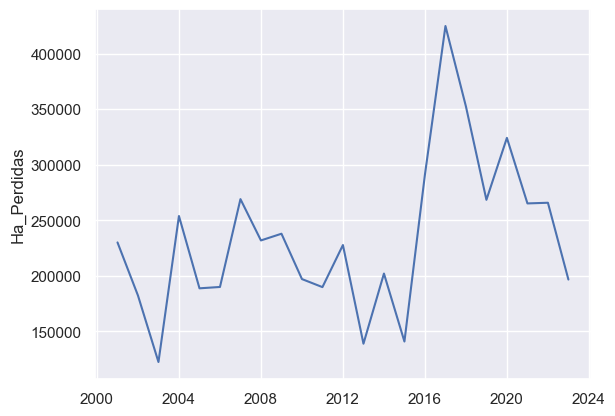

In [ ]:
#Convertimos la fecha en el índice
df.set_index('año_registrado',inplace=True)
plt.plot(df)
plt.ylabel('Ha_Perdidas')
plt.show()

In [ ]:
#También podemos calcular la media anual de Ha Perdidas
media_five = df.resample("5AS").mean()
media_five

C:\Users\Flia Castiblanco\AppData\Local\Temp\ipykernel_10360\4256093596.py:2: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  media_five = df.resample("5AS").mean()


,Ha_Perdidas
año_registrado,
2001-01-01,195456.956000
2006-01-01,225160.138000
2011-01-01,179863.546000
2016-01-01,332167.988000
2021-01-01,242528.023333


In [ ]:
# Podemos ver cómo cambia porcentualmente la media anual de pasajeros
media_five.pct_change()

,Ha_Perdidas
año_registrado,
2001-01-01,NaN
2006-01-01,0.151968
2011-01-01,-0.201175
2016-01-01,0.846778
2021-01-01,-0.269863


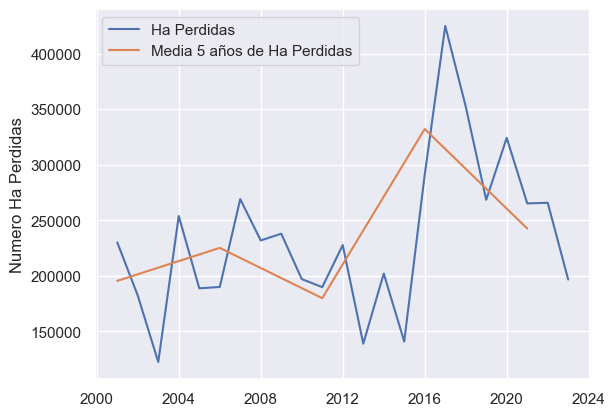

In [ ]:
# Media Anual de Ha
plt.plot(df,label='Ha Perdidas')
plt.plot(media_five,label='Media 5 años de Ha Perdidas')
plt.legend()
plt.ylabel('Numero Ha Perdidas')
plt.show()

In [ ]:
#Podemos Usar métricas móviles para ver el comportamiento de la serie
rolling_mean = df['Ha_Perdidas'].rolling(5).mean()     # Media
rolling_var = df['Ha_Perdidas'].rolling(5).var()     # Varianza
rolling_std = df['Ha_Perdidas'].rolling(5).std()     # Desviación Estandar


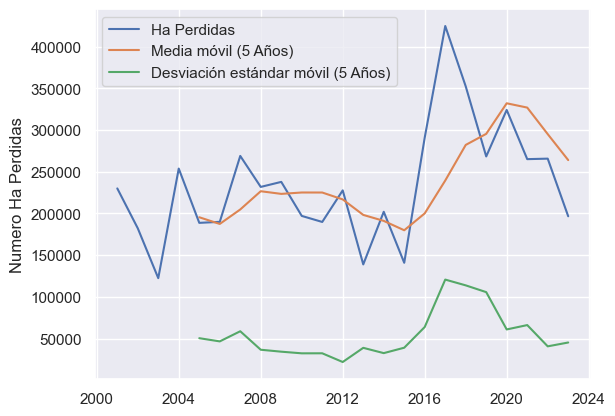

In [ ]:
plt.plot(df,label='Ha Perdidas')
plt.plot(rolling_mean, label="Media móvil (5 Años)")
plt.plot(rolling_std, label="Desviación estándar móvil (5 Años)")
plt.legend()
plt.ylabel('Numero Ha Perdidas')
plt.show()

Otra forma de analizar la estacionalidad de una serie es con el test Dickey-Fuller. En esta prueba se evaúa la hipotesis nula que confirma que la serie no es estacionaria.
* Si el p-value es mayor que 0.05, entonces no podemos rechazar la hipotesis de que la serie no es estacionarioa
* Si el p-value es menor que 0.05, entoces podremos rechazar la hipotesis nula y decir que la serie es estacionaria

In [ ]:
# Para ejecutar el test anterior importamos adfuller y...
adft = adfuller(df['Ha_Perdidas'],autolag="AIC")

adft

(np.float64(-2.6972053038269954),
 np.float64(0.07452312332400195),
 0,
 22,
 {'1%': np.float64(-3.769732625845229),
  '5%': np.float64(-3.005425537190083),
  '10%': np.float64(-2.6425009917355373)},
 np.float64(330.44449103028467))

In [ ]:
# Mostrar datos anteriores en una DataFrame
output_df = pd.DataFrame({ "Values": [adft[0], adft[1], adft[2],adft[3],adft[4]['1%'],
                                    adft[4]['5%'], adft[4]['10%']],
                                    "Metric":["Test Statistics", "p-value", "No. of lags used",
                                              "Number of observations used", "critical value(1%)",
                                              "critical value(5%)","critical value(10%)"]})

output_df

,Values,Metric
0,-2.697205,Test Statistics
1,0.074523,p-value
2,0.000000,No. of lags used
3,22.000000,Number of observations used
4,-3.769733,critical value(1%)
5,-3.005426,critical value(5%)
6,-2.642501,critical value(10%)


#### **Analisis de Autocorrelación**

### Descompisición de Series


In [ ]:
# Para esto, Importamos "from statsmodels.tsa.seasonal import seasonal_decompose"

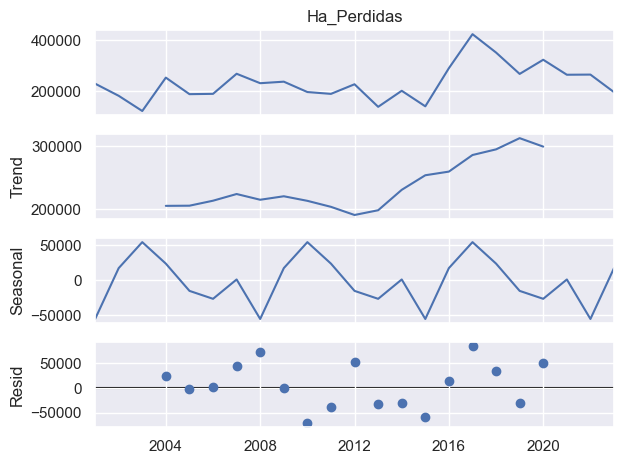

In [ ]:
decompose = seasonal_decompose(df["Ha_Perdidas"], model='additive', period=7)
decompose.plot()
plt.show()

# Pronostico ARIMA 2
Modelo S-ARIMA

In [ ]:
# import mysql.connector  # Importar el conector de MySQL
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.seasonal import seasonal_decompose
# from sklearn.metrics import mean_squared_error, r2_score

# from statsmodels.tsa.arima.model import ARIMA #Este no es, es el siguiente
from statsmodels.tsa.arima_model import ARIMA

modelo = sm.tsa.statespace.SARIMAX(baseA['Ha_Perdidas'], order = (1,1,1), seasonal_order = (0,1,0,12))


In [ ]:
resultados = modelo.fit()
print(resultados.summary())

In [ ]:
resultados.resid

In [ ]:
resultados.resid.plot()

# Prueba Pronostico ARIMA
Graficado

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  wa

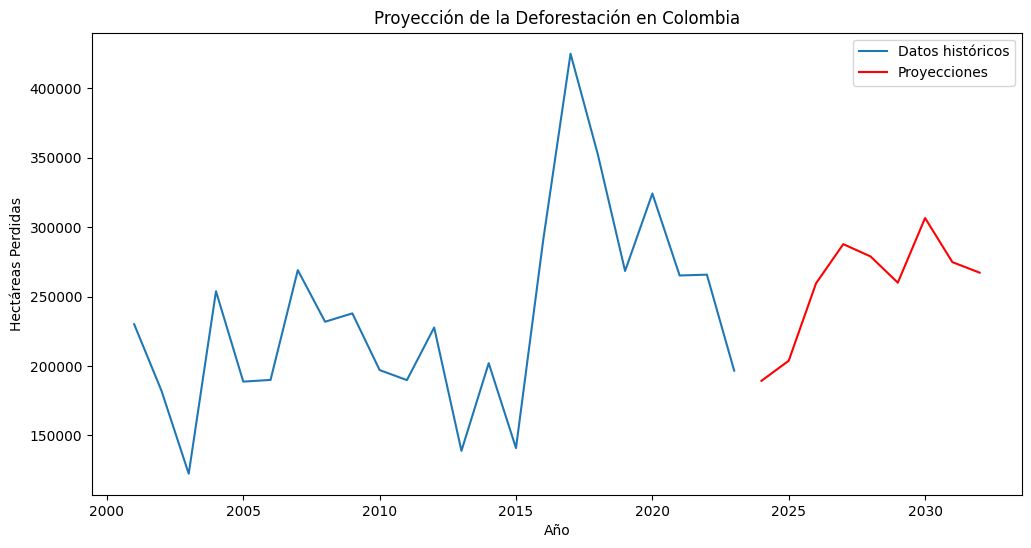

2024    189304.429390
2025    203769.650185
2026    259453.545434
2027    287739.930482
2028    278899.009014
2029    259992.169239
2030    306542.612813
2031    274796.756749
2032    267200.191767
Name: predicted_mean, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Datos de deforestación
data = {
    'año_registrado': [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'Ha_Perdidas': [230054.83, 182229.13, 122417.12, 253840.01, 188743.69, 189963.60, 269029.28, 231849.51, 237890.87, 197067.43, 189829.00, 227707.01, 138898.14, 202027.89, 140855.69, 290956.31, 424870.26, 352434.02, 268409.90, 324169.45, 265167.73, 265769.26, 196647.08]
}

df = pd.DataFrame(data)
df.set_index('año_registrado', inplace=True)

# Ajustar el modelo ARIMA
model = ARIMA(df['Ha_Perdidas'], order=(10, 1, 1))
model_fit = model.fit()

# Hacer predicciones hasta el año 2032
predictions = model_fit.predict(start=len(df), end=len(df) + 8, typ='levels')
predictions.index = range(2024, 2033)

# Visualización
plt.figure(figsize=(12, 6))
plt.plot(df, label='Datos históricos')
plt.plot(predictions, label='Proyecciones', color='red')
plt.xlabel('Año')
plt.ylabel('Hectáreas Perdidas')
plt.title('Proyección de la Deforestación en Colombia')
plt.legend()
plt.show()

print(predictions)


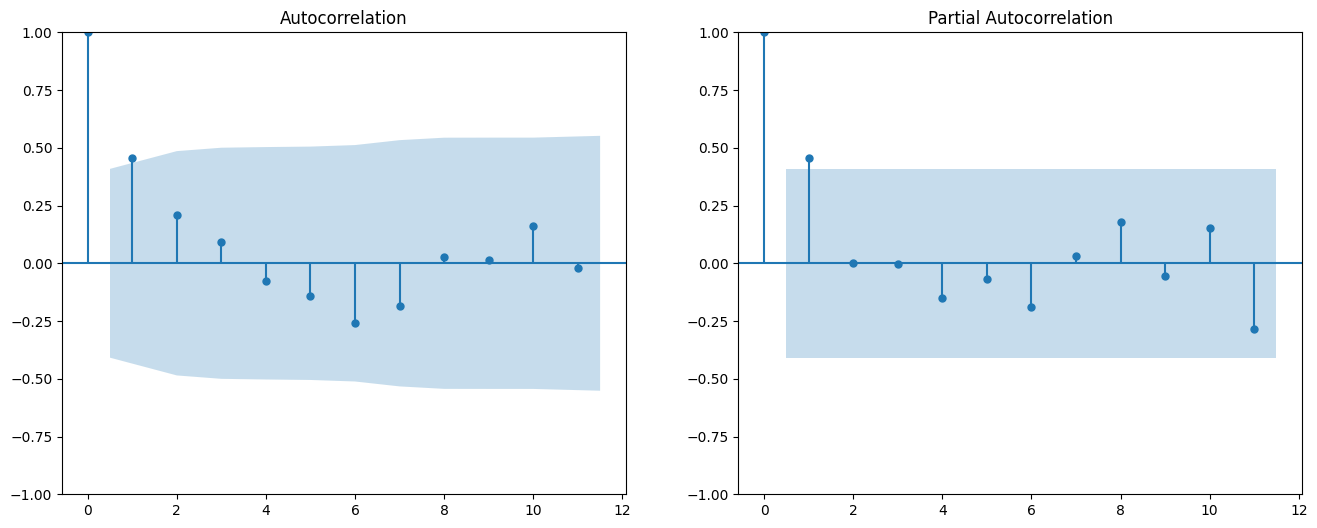

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for 

Mejor orden para ARIMA: (3, 2, 5)


In [ ]:
# Tus datos de deforestación
data = {
    'año_registrado': [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'Ha_Perdidas': [230054.83, 182229.13, 122417.12, 253840.01, 188743.69, 189963.60, 269029.28, 231849.51, 237890.87, 197067.43, 189829.00, 227707.01, 138898.14, 202027.89, 140855.69, 290956.31, 424870.26, 352434.02, 268409.90, 324169.45, 265167.73, 265769.26, 196647.08]
}

df = pd.DataFrame(data)
df.set_index('año_registrado', inplace=True)

# Graficar ACF y PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df['Ha_Perdidas'], ax=axes[0])
plot_pacf(df['Ha_Perdidas'], ax=axes[1])
plt.show()

# Probar diferentes órdenes para ARIMA
def evaluate_arima_order(data, max_p, max_d, max_q):
    best_aic = np.inf
    best_order = None
    for p in range(max_p+1):
        for d in range(max_d+1):
            for q in range(max_q+1):
                try:
                    model = ARIMA(data, order=(p, d, q))
                    model_fit = model.fit()
                    if model_fit.aic < best_aic:
                        best_aic = model_fit.aic
                        best_order = (p, d, q)
                except:
                    continue
    return best_order

# best_order = evaluate_arima_order(df['Ha_Perdidas'], 5, 2, 5)
best_order = evaluate_arima_order(df['Ha_Perdidas'], 5, 2, 5)
print("Mejor orden para ARIMA:", best_order)


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except fo

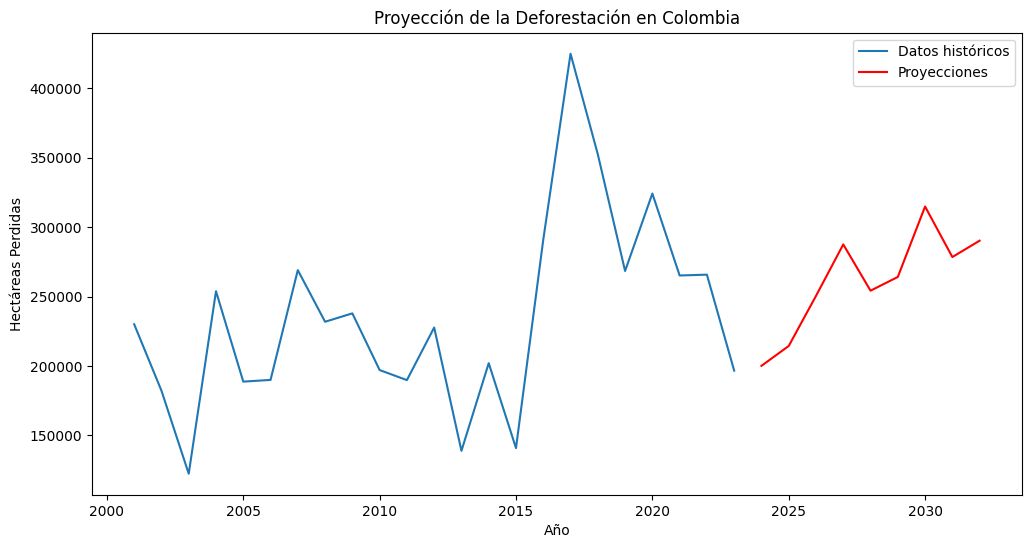

2024    200111.930444
2025    214413.519319
2026    250471.976849
2027    287539.899739
2028    254228.403316
2029    264119.943979
2030    314828.515529
2031    278456.285176
2032    290246.371528
Name: predicted_mean, dtype: float64


In [ ]:
# Ajustar el modelo ARIMA -- Order = (p,d,q)
# Mejores p  =  ---------10    -       -4 - 10
# Mejores q  = 6- 8     -10        -11
model = ARIMA(df['Ha_Perdidas'], order=(10, 1, 11))
model_fit = model.fit()

# Hacer predicciones hasta el año 2032
predictions = model_fit.predict(start=len(df), end=len(df) + 8, typ='levels')
predictions.index = range(2024, 2033)

# Visualización
plt.figure(figsize=(12, 6))
plt.plot(df, label='Datos históricos')
plt.plot(predictions, label='Proyecciones', color='red')
plt.xlabel('Año')
plt.ylabel('Hectáreas Perdidas')
plt.title('Proyección de la Deforestación en Colombia')
plt.legend()
plt.show()

print(predictions)


# Prueba de Parametros con ARIMA

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Datos de deforestación
data2 = [230054.83, 182229.13, 122417.12, 253840.01, 188743.69, 189963.60, 269029.28, 231849.51, 237890.87, 197067.43, 189829.00, 227707.01, 138898.14, 202027.89, 140855.69, 290956.31, 424870.26, 352434.02, 268409.90, 324169.45, 265167.73, 265769.26, 196647.08]


# Convertir a una serie temporal
data_series = pd.Series(data2)

# Ajustar el modelo ARIMA (3,1,3)
model = ARIMA(data_series, order=(2,1,3))
model_fit = model.fit()
#Resumen del Modelo
print (model_fit.summary())


c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   23
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -275.643
Date:                Mon, 28 Oct 2024   AIC                            563.286
Time:                        11:29:53   BIC                            569.832
Sample:                             0   HQIC                           564.828
                                 - 23                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1858      2.496      0.074      0.941      -4.706       5.077
ar.L2          0.3998      1.074      0.372      0.710      -1.705       2.505
ma.L1         -0.5057      2.447     -0.207      0.8

In [ ]:
forecast = model_fit.forecast(step = 10)
print(forecast)

23    212901.3791
dtype: float64


c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
